In [3]:
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abnumber import Chain

In [4]:
config = {
    "embedding": ("berty", 512),
    # [("berty", 512), ("ab", 768), ("prot", 1024), ("balm", 640), ("esm", 1280), ("ig", 1024)]
    "input_type": "chain",  # ["cdr", "chain"]
    "max_len": 150,  # [35, 150]
}

In [5]:
with open("embeddings/embeddings.p", "rb") as f:
    embedding_dict = pickle.load(f)

with open("embeddings/ab_embeddings.p", "rb") as f:
    ab_embedding_dict = pickle.load(f)

with open("embeddings/prot_embeddings.p", "rb") as f:
    prot_embedding_dict = pickle.load(f)

with open("embeddings/balm_embeddings.p", "rb") as f:
    balm_embedding_dict = pickle.load(f)

with open("embeddings/esm_embeddings.p", "rb") as f:
    esm_embedding_dict = pickle.load(f)

with open("embeddings/ig_embeddings.p", "rb") as f:
    ig_embedding_dict = pickle.load(f)


def encode(sequence, pos, config):
    encoded = torch.zeros((config['max_len'], config['embedding'][1] + 7))
    if config['embedding'][0] == 'berty':
        encoded[:len(sequence)] = torch.cat((embedding_dict[sequence].cpu(), pos[:len(sequence)]), dim=1)
    elif config['embedding'][0] == 'ab':
        encoded[:len(sequence)] = torch.cat((torch.tensor(ab_embedding_dict[sequence]), pos[:len(sequence)]), dim=1)
    elif config['embedding'][0] == 'prot':
        encoded[:len(sequence)] = torch.cat((prot_embedding_dict[sequence], pos[:len(sequence)]), dim=1)
    elif config['embedding'][0] == 'balm':
        encoded[:len(sequence)] = torch.cat((balm_embedding_dict[sequence], pos[:len(sequence)]), dim=1)
    elif config['embedding'][0] == 'ig':
        encoded[:len(sequence)] = torch.cat((ig_embedding_dict[sequence][:, 0, :].squeeze(1), pos[:len(sequence)]), dim=1)
    elif config['embedding'][0] == 'esm':
        encoded[:len(sequence)] = torch.cat((esm_embedding_dict[sequence], pos[:len(sequence)]), dim=1)
    else:
        print("Not Proper embedding name selected!")
        exit()

    return encoded

def encode_batch(batch_of_sequences, positions, encoder, config):
    embeddings = [encoder(seq, pos, config) for seq, pos in zip(batch_of_sequences, positions)]
    seq_lens = [len(seq) for seq in batch_of_sequences]
    return torch.stack(embeddings), torch.as_tensor(seq_lens)

### for Predicting Whole dataset

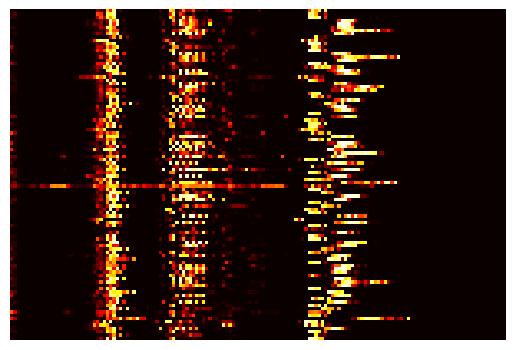

In [6]:
from data.data_loader import get_positions, to_binary, pad_position_list
from utils import initiate_system_device

# Load Data
df = pd.read_csv("data/chains_parapred.csv")
chains = [x for x in df['sequence'].tolist()]
positions = [torch.tensor(pad_position_list(p, config['max_len'])) for p in get_positions(df)]
labels = [to_binary(x, config['max_len']) for x in df['paratope'].tolist()]

# Load model
device = initiate_system_device()
model = torch.load(f"best_models/{config['input_type']}_{config['embedding'][0]}.pth").to(device)
with open(f"best_models/{config['input_type']}_{config['embedding'][0]}_tresh.txt", "r") as f:
    tresh = float(f.read())

# Predict Paratopes
embeddings, lengths = encode_batch(chains, positions, encode, config)
embeddings = embeddings.to(device)
probabilities = model(embeddings).squeeze(2).type(torch.float64).cpu()

# Plot Heatmap
plt.imshow(probabilities.detach().numpy()[:100], cmap='hot')
plt.axis('off')
plt.savefig(f"figures/{config['input_type']}_heatmap.tiff", dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight', pad_inches=0)
plt.show()

### Input a Seq

In [10]:
def get_chain_pos(input_seq):
    chain = Chain(input_seq, scheme='chothia')
    
    poses = []
    for p in chain.positions:
        if chain.is_heavy_chain():
            if p in chain.cdr1_dict or p in list(chain.fr1_dict.keys)[-2:] or p in list(chain.fr2_dict.keys)[:2]:
                poses.append([1, 0, 0, 0, 0, 0, 0])
            elif p in chain.cdr2_dict or p in list(chain.fr2_dict.keys())[-2:] or p in list(chain.fr3_dict.keys())[:2]:
                poses.append([0, 1, 0, 0, 0, 0, 0])
            elif p in chain.cdr3_dict or p in list(chain.fr3_dict.keys())[-2:] or p in list(chain.fr4_dict.keys())[:2]:
                poses.append([0, 0, 1, 0, 0, 0, 0])
            else:
                poses.append([0, 0, 0, 0, 0, 0, 1])
        else:
            if p in chain.cdr1_dict or p in list(chain.fr1_dict.keys())[-2:] or p in list(chain.fr2_dict.keys())[:2]:
                poses.append([0, 0, 0, 1, 0, 0, 0])
            elif p in chain.cdr2_dict or p in list(chain.fr2_dict.keys())[-2:] or p in list(chain.fr3_dict.keys())[:2]:
                poses.append([0, 0, 0, 0, 1, 0, 0])
            elif p in chain.cdr3_dict or p in list(chain.fr3_dict.keys())[-2:] or p in list(chain.fr4_dict.keys())[:2]:
                poses.append([0, 0, 0, 0, 0, 1, 0])
            else:
                poses.append([0, 0, 0, 0, 0, 0, 1])
    
    return torch.tensor(np.vstack((np.array(poses), np.array([[0, 0, 0, 0, 0, 0, 0] for _ in range(config['max_len'] - len(input_seq))]))))

def get_cdr_pos(seq, cdr):
    cdrs = ['L1', 'L2', 'L3', 'H1', 'H2', 'H3', 'XX']
    zero_list = [0, 0, 0, 0, 0, 0, 0]
    zero_list[cdrs.index(cdr)] = 1
    position = np.array([zero_list for _ in range(len(seq))])
    return torch.tensor(np.vstack((position, np.array([[0, 0, 0, 0, 0, 0, 0] for _ in range(config['max_len'] - len(seq))]))))

In [ ]:
def get_embeddings(seq, cdr):
    encoded = torch.zeros((config['max_len'], config['embedding'][1] + 7))
    if config['input_type'] == 'cdr':
        pos = get_cdr_pos(seq, cdr)[:len(seq)]
    else:
        pos = get_chain_pos(seq)
    emb = None

    if config['embedding'][0] == 'berty':
        from igfold import IgFoldRunner
        igfold = IgFoldRunner()
        emb = igfold.embed(sequences={"Seq": seq}).bert_embs.cpu()
    elif config['embedding'][0] == 'ab':
        import ablang
        if cdr[0] == 'H':
            heavy_ablang = ablang.pretrained("heavy")
            heavy_ablang.freeze()
            emb = torch.tensor(heavy_ablang([seq], mode='rescoding'))
        else:
            light_ablang = ablang.pretrained("light")
            light_ablang.freeze()
            emb = torch.tensor(light_ablang([seq], mode='rescoding'))
    elif config['embedding'][0] == 'prot':
        from transformers import T5Tokenizer, T5EncoderModel

        tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
        model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc")
        
        ids = tokenizer([" ".join(list(seq))], return_tensors="pt")
        emb = model(input_ids=ids['input_ids'], attention_mask=ids['attention_mask']).last_hidden_state[0, :-1]
    elif config['embedding'][0] == 'balm':
        from embeddings.BALM.modeling_balm import BALMForMaskedLM
        from transformers import EsmTokenizer
        import torch
        
        tokenizer = EsmTokenizer.from_pretrained("BALM/tokenizer/vocab.txt", do_lower_case=False)
        model = BALMForMaskedLM.from_pretrained("./BALM/pretrained-BALM/")
        
        tokenizer_input = tokenizer(seq, return_tensors="pt", add_special_tokens=False)
        emb = model(**tokenizer_input, return_dict=True, output_hidden_states=True, output_attentions=True).hidden_states[-1].squeeze(0)
    elif config['embedding'][0] == 'ig':
        from transformers import BertModel, BertTokenizer

        tokeniser = BertTokenizer.from_pretrained("Exscientia/IgBert_unpaired", do_lower_case=False)
        model = BertModel.from_pretrained("Exscientia/IgBert_unpaired", add_pooling_layer=False)
        
        sequences = [' '.join(c) for c in seq]
        tokens = tokeniser.batch_encode_plus(
            sequences,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_tensors="pt",
            return_special_tokens_mask=True
        )
        emb = model(
            input_ids=tokens['input_ids'],
            attention_mask=tokens['attention_mask']
        ).last_hidden_state[:, 0, :].squeeze(1)
    elif config['embedding'][0] == 'esm':
        import esm

        model, alphabet = esm.pretrained.esm2_t48_15B_UR50D()
        batch_converter = alphabet.get_batch_converter()
        model.eval()  # disables dropout for deterministic results
        
        batch_labels, batch_strs, batch_tokens = batch_converter([("", seq)])
        
        with torch.no_grad():
            emb = model(batch_tokens, repr_layers=[33], return_contacts=True)["representations"][0, 1: -1]
        
    encoded[:len(seq)] = torch.cat((emb, pos), dim=1)
    return encoded

In [11]:
# seq = 'ASGYTFTSYWI'
seq = 'DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKLLIYTASTLQSGVPSRFSGSASGTDFTLTINSLQPEDFATYSCQQSYNSPWTFGQGTKVEIK'
cdr = 'L1' # ['L1', 'L2', 'L3', 'H1', 'H2', 'H3', 'XX'] Does not care when it is Chain and input XX if you don't know where does it belong

embedding = get_embeddings(seq, cdr).to(device)
embedding = torch.unsqueeze(embedding, 0)
probabilities = model(embedding).squeeze(2).type(torch.float64).cpu()

for s, p in zip(seq, probabilities.tolist()[0]):
    print(s, '\t', round(p, 5))

UnboundLocalError: cannot access local variable 'torch' where it is not associated with a value